In [341]:
import os
import shutil
os.chdir('/content')
if os.path.isdir('./hetvae'):
  shutil.rmtree('./hetvae/')
! git clone https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! git checkout error_bars

! pip install -r requirements.txt

os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
import utils
import my_utils
import importlib
import vae_models
importlib.reload(vae_models)
importlib.reload(models)
importlib.reload(my_utils)
importlib.reload(utils)
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline


Cloning into 'hetvae'...
remote: Enumerating objects: 424, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 424 (delta 127), reused 112 (delta 58), pack-reused 237
Receiving objects: 100% (424/424), 19.78 MiB | 17.45 MiB/s, done.
Resolving deltas: 100% (268/268), done.
Branch 'error_bars' set up to track remote branch 'error_bars' from 'origin'.
Switched to a new branch 'error_bars'


In [342]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/EDELSON/*')[:4]
lcs,max_len = my_utils.file_to_np(*(lc_files*100))
lcs = lcs[:64]

lcs, starts, max_len = my_utils.zero_start(lcs)
lcs = my_utils.handle_dups(lcs)
union_tp = my_utils.union_timepoints(lcs)
print(len(union_tp))
lcs = my_utils.include_union_tp(lcs, max_len)
lcs.shape
#----------------------------------------------------------------------------------------------------------
# NORMALIZING
#----------------------------------------------------------------------------------------------------------

std_time = np.std(union_tp)
#std_flux = np.std(lcs[:,:,1].flatten())
#mean_flux = np.mean(lcs[:,:,1].flatten())
union_tp = union_tp / std_time
lcs[:,:,0] = lcs[:,:,0] / std_time

# normalize flux for light curves individually
for lc in lcs:
    lc[:,1] = lc[:,1] / np.std(lc[:,1])

    lc[:,2] = lc[:,2] / np.std(lc[:,2])

# ----------------------------------------------------------------------------------------------------------
lcs = lcs.astype(np.float32)
union_tp = union_tp.astype(np.float32)
union_tp = torch.tensor(union_tp)


smask, rmask = my_utils.make_masks(lcs, frac=0.5)




dims of /content/hetvae/data/EDELSON/NGC4593_M2.dat:	(148, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W2.dat:	(259, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_HX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_M2.dat:	(148, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W2.dat:	(259, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_HX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_M2.dat:	(148, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W2.dat:	(259, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_HX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_M2.dat:	(148, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W2.dat:	(259, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_HX.dat:	(190, 3)
dims of 

In [343]:
print(lcs.shape, smask.shape)
lcs = np.concatenate((lcs, smask[:,:,np.newaxis], rmask[:,:,np.newaxis]), axis=-1)
print(lcs.shape)

(64, 267, 3) (64, 267)
(64, 267, 5)


In [344]:
train_loader = torch.utils.data.DataLoader(lcs, batch_size=8)
dim = 1
print(f"{lcs.shape}")
#-----------------------------------------------------------------------------------------------------------
#MASKS
#-----------------------------------------------------------------------------------------------------------

print(f"{smask[-1].shape}")
print(smask[0][0].sum(), rmask[0][0].sum())


(64, 267, 5)
(267,)
0.0 1.0



## Setting up arguments

In [345]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [352]:
# num heads?
args = Namespace(batch_size=8, bound_variance=True, const_var=False, dataset='toy', dropout=0.0, 
                 elbo_weight=1.0, embed_time=256, enc_num_heads=1, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.000001, mixing='concat', mse_weight=0.0, n=256, net='hetvae', 
                 niters=1000, norm=False, normalize_input='znorm', num_ref_points=128, rec_hidden=128, recon_loss=False, 
                 sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=1024)

In [353]:
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

In [354]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **Generating Synthetic Data**

In [314]:
# why is it subtracting 1 for the recon mask?
# dataset class that loads agn by folder you give it? agn object, agn.addLC('').addLC('')
# what is happening with the normalizations...
# kl negative? negative losses in general???
# make this capable of running on GPU
# fixing visualization
# adding error bars in the loss function?
# is my union_tp right? 
# different sequence sizes, some drastically shorter... how to make this not matter? does it? 


# do we subsample the light curve like they do...?
# i guess we do because you're just randomly selecting points each go round...




## **Loading HeTVAE model**

In [364]:
net = models.load_network(args, dim, union_tp) # dim = 1
params = list(net.parameters())
optimizer = optim.Adam(params, lr=.001)
# definitly want a decaying error rate...
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)


## **Training**

In [368]:
def train(net, optimizer,epoch, train_loader):
      train_loss = 0.
      train_n = 0.
      avg_loglik, avg_kl, mse, mae = 0., 0., 0., 0.
      for i, train_batch in enumerate(train_loader):
          batch_len = train_batch.shape[0] 
          train_batch = train_batch.to(device)
          subsampled_mask = train_batch[:,:,3:4]
          recon_mask = train_batch[:,:,4:]

          seqlen = train_batch.size(1) 
          # subsampled flux values and their corresponding masks....
          context_y = torch.cat((
              train_batch[:, :, 1:2] * subsampled_mask, subsampled_mask
          ), -1) 

    # #   def compute_unsupervised_loss(self, context_x, context_y, target_x, target_y, num_samples=1, beta=1):
          loss_info = net.compute_unsupervised_loss(
              train_batch[:, :, 0], # context_x, times
              context_y,             # context_y
              train_batch[:, :, 0], # target_x, same times? 
              torch.cat((            # flux values with only recon_mask values showing
                  train_batch[:, :, 1:2] * recon_mask, recon_mask
              ), -1),
              num_samples=args.k_iwae, # 1? 
              beta=1,
              # optional, will be zero if not set
              error_bars = train_batch[:,:,2:3],    # ? 
          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          #scheduler.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
          
          # if train_loss < 1:
          #   break
      
      # if train_loss <= 5:
      #   return
      
      if epoch % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  epoch,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
      
      
        # no test data yet
    #       for loader, num_samples in [(val_loader, 5), (test_loader, 100)]:
    #           utils.evaluate_hetvae(
    #               net,
    #               dim,
    #               loader,
    #               0.5,
    #               shuffle=False,
    #               k_iwae=num_samples,
    #               model_name=args.net,
    #           )


In [372]:
for epoch in range(201, 2000+1):#args.niters + 1):
    train(net, optimizer, epoch, train_loader)
    scheduler.step()

Iter: 300, train loss: 3423.5694, avg nll: -88.7994, avg kl: 3512.3689, mse: 1.108487, mae: 3.348435
Iter: 400, train loss: 3059.9213, avg nll: 249.8374, avg kl: 2810.0840, mse: 2.415863, mae: 4.486310
Iter: 500, train loss: 1672.0953, avg nll: -295.7829, avg kl: 1967.8782, mse: 0.374591, mae: 1.861240
Iter: 600, train loss: 1310.7839, avg nll: -331.5821, avg kl: 1642.3660, mse: 0.259701, mae: 1.208730
Iter: 700, train loss: 1400.0046, avg nll: -0.9670, avg kl: 1400.9716, mse: 1.396976, mae: 3.873845
Iter: 800, train loss: 1660.4968, avg nll: 447.2329, avg kl: 1213.2637, mse: 3.147436, mae: 4.926645


KeyboardInterrupt: ignored

In [371]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.01

0.001


In [ ]:
torch.save(net, 'weights.pt')

In [ ]:
net = torch.load('weights.pt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
torch.save(net, 'weights.pt')

Mounted at /content/drive/


In [ ]:
# ! git config --global user.email 'mattlowery10@gmail.com'
# ! git config --global user.name 'mwl10'
# username = 'mwl10'
# repository = 'hetvae'

# ! git remote add origin https://@github.com/mwl10/hetvae.git
# ! git add .
# ! git commit -m "test upload some weights"
# ! git push origin main

fatal: remote origin already exists.
On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


0.0001


## **Vizualization with increasing number of observations**

In [375]:

def viz(test_loader, net, k_iwae=1, n_max=10, ):
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    np.random.seed(0)
    # don't keep track of gradients....
    with torch.no_grad():
        # how many points we show in the light curve? 
        for low in [10,30,50]:
            for i, batch in enumerate(test_loader):
                
                batch_len = batch.shape[0]
                batch = batch.to(device)
                #subsampled_mask = torch.zeros_like(batch[:, :, dim:2 * dim]).to(device)
                subsampled_mask = batch[:,:,3:4]
                seqlen = batch.size(1)
                # for i in range(batch_len):
                  
                #     length = low
                #     obs_points = np.sort(np.random.choice(np.arange(seqlen), size=length, replace=False))
                #     subsampled_mask[i, obs_points, :] = 1
                #recon_mask = batch[:, :, dim:2 * dim] - subsampled_mask
                context_y = torch.cat((batch[:, :, 1:2] * subsampled_mask, subsampled_mask), -1)
                px, _ = net.get_reconstruction(batch[:, :, 0], context_y, batch[:, :, 0], num_samples=k_iwae)
                pred_mean.append(px.mean.cpu().numpy())
                pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
                targets.append((batch[:, :, 1:2]).cpu().numpy())
                masks.append(subsampled_mask.cpu().numpy())
                tp.append(batch[:, :, 0].cpu().numpy())
                if len(tp) % (n_max // 5) == 0:
                    break
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
    preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    quantile2 = np.quantile(preds, 0.99, axis=0)
    quantile1 = np.quantile(preds, 0.01, axis=0)
    print(preds.shape)
    print("pay attention", quantile1.shape)
    print(preds)
    
    w = 2.0
    for index in range(n_max):
        plt.figure(figsize=(12.5, 1.5))
        for j in range(3):
            plt.subplot(1, 3, j + 1)
            plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
            plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
            #plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
            plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='k', lw=w, label='Observed Data')
            plt.xlim([0, 1])
            plt.xticks([])
            plt.yticks([])
            if j == 1 and index == 0:
                plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
            
        plt.show()


In [ ]:

# torch.cuda.empty_cache()
# pred_mean, pred_std = [],[]
# masks = []
# targets = []
# tp = []
# k_iwae = 10
# np.random.seed(0)
# with torch.no_grad():
#   batch = next(iter(train_loader)).to(device)
#   print(batch.shape)
#   batch_len = len(batch)
#   subsampled_mask = torch.tensor(smask[i][:, :, np.newaxis]).to(device)
#   seqlen = batch.size(1)
#   context_y = torch.cat((batch[:,:,1:2] * subsampled_mask, subsampled_mask), -1)
#   context_y = torch.cat((batch[:, :, :dim] * subsampled_mask, subsampled_mask), -1)
#   px, _ = net.get_reconstruction(batch[:, :, 0], context_y, batch[:, :, 0], num_samples=k_iwae)
#   pred = px.mean.cpu().numpy()
#   pred_std = torch.exp(0.5 * px.logvar).cpu().numpy() # e^(0.5 * logvar)

# points = batch.cpu().numpy()


torch.Size([8, 147, 3])


(20, 48, 267, 1) (20, 48, 267, 1) (48, 267, 1) (48, 267, 1) (48, 267)
(200, 48, 267, 1)
pay attention (48, 267, 1)
[[[[ 1.01815086]
   [ 1.00451191]
   [ 1.01029771]
   ...
   [ 0.98114754]
   [ 1.00239812]
   [ 1.00574925]]

  [[ 5.07791726]
   [ 5.07392418]
   [ 5.07800704]
   ...
   [ 1.22572055]
   [ 2.32626219]
   [ 3.26617343]]

  [[ 5.14746903]
   [ 5.15441161]
   [ 5.15764947]
   ...
   [ 5.15601929]
   [ 5.15196628]
   [ 5.17437764]]

  ...

  [[ 0.23831992]
   [ 0.24071434]
   [ 0.239068  ]
   ...
   [ 3.51510806]
   [ 3.54677499]
   [ 1.66582787]]

  [[ 4.67623368]
   [ 4.67812544]
   [ 4.69197235]
   ...
   [ 4.67489596]
   [ 4.68464481]
   [ 4.66699926]]

  [[-0.63522891]
   [-0.64559026]
   [-0.63402261]
   ...
   [-0.63813806]
   [-0.65248421]
   [-0.65092399]]]


 [[[-0.18932433]
   [-0.18334706]
   [-0.16025323]
   ...
   [-0.18238053]
   [-0.192005  ]
   [-0.20005755]]

  [[ 0.16626468]
   [ 0.17639061]
   [ 0.17569314]
   ...
   [ 3.69169198]
   [ 4.01289256]
   [ 3.

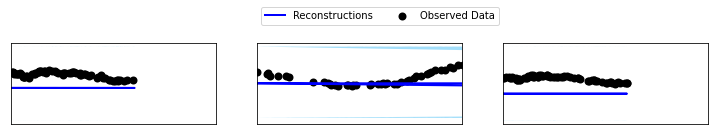

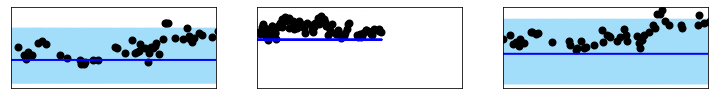

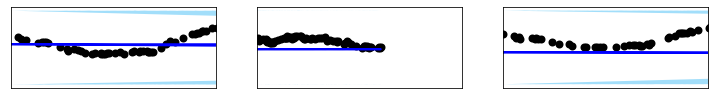

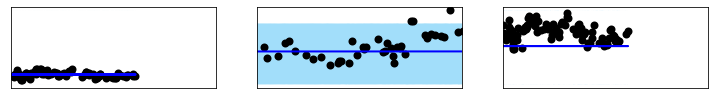

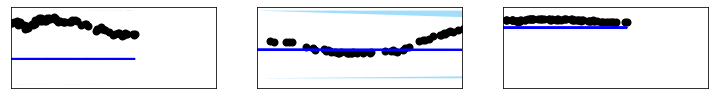

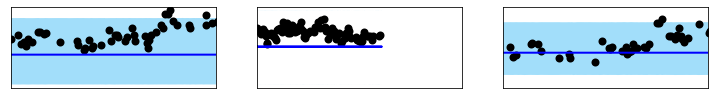

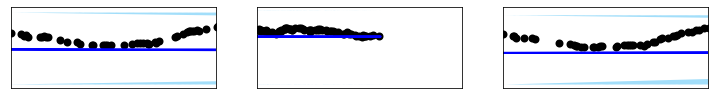

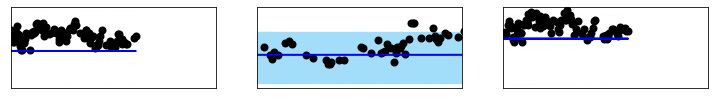

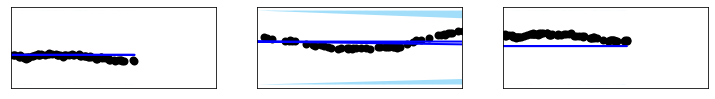

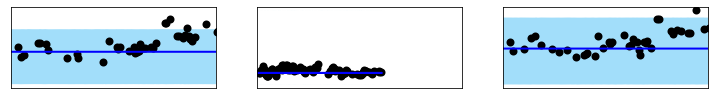

In [376]:
viz(train_loader, net, k_iwae=20)